# Import

In [ ]:
import keras_ocr

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import json
import copy
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import strip_tags
from gensim.parsing.preprocessing import strip_short
from gensim.parsing.preprocessing import strip_multiple_whitespaces
from gensim.parsing.preprocessing import stem_text
from gensim.parsing.preprocessing import strip_numeric
from spellchecker import SpellChecker


CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, lambda x: strip_short(x, minsize=2), 
                  strip_multiple_whitespaces, strip_numeric, stem_text]

SPELLCHECKER = SpellChecker(local_dictionary='word_frequency.json', distance=2)  # loads default word frequency list


def check_spelling(phrase):
    phrase_dict = {}
    for word in phrase:
        phrase_dict[word] = word
    misspelled = SPELLCHECKER.unknown(phrase)
    corrected = word
    for word in misspelled:
        # Get the one `most likely` answer
        corrected = SPELLCHECKER.correction(word)
        phrase_dict[word] = corrected

    return list(phrase_dict.values())
    

def transform_to_keras_ocr(ocr):
    keras_ocr = []
    
    for lines in ocr["line_boxes"]:
        [[x0, y0], [x1, y1]] = lines["bbox"]
        new_bbox = np.array([[x0, y0], [x1, y0], [x1, y1], [x0, y1]], dtype=np.float32)
        sentence_line = ""
        for word in lines["word_boxes"]:
            sentence_line += " " + word["text"]
        sentence_line = sentence_line[1:]
        keras_ocr.append((sentence_line, new_bbox))
    return keras_ocr

def get_image_sizes(image):
    return image.shape

def transform_coordinates_simplified(word_position):
    x0, y0 = int(word_position[0][0]), int(word_position[0][1])
    x1, y1 = int(word_position[2][0]), int(word_position[2][1])
    return [[x0, y0], [x1, y1]]
    

def transform_to_simple_ocr_format(image, prediction):
    ocr = {}
    (height, width, _) = image.shape
    ocr["image_sizes"] = [width, height]
    ocr["word_boxes"] = []
    for word_text, word_position in prediction:
        simplified_coordinates = transform_coordinates_simplified(word_position)
        if word_text.isnumeric() or len(word_text) == 1:
            continue
        ocr["word_boxes"].append({"bbox": simplified_coordinates, "text": word_text})
    return ocr

def overlapping_height_boxes(box_1, box_2, threshold):
    [[l_x0, l_y0], [l_x1, l_y1]] = box_1
    [[o_x0, o_y0], [o_x1, o_y1]] = box_2
    dy = min(l_y1, o_y1) - max(l_y0, o_y0)
    if (l_y1 - l_y0) == 0:
        return False
    if (dy / (l_y1 - l_y0) >= threshold):
        return True
    return False


def get_ocr_line_boxes(ocr_word_boxes, threshold=0.6):
    
    boxes_not_processed = ocr_word_boxes["word_boxes"]
    line_boxes = [] 
    while len(boxes_not_processed) != 0:
        current_word_box = boxes_not_processed[0]
        current_bbox = current_word_box["bbox"]
        del boxes_not_processed[0]
        index_to_delete = []
        biggest_word_box = copy.deepcopy(current_bbox)
        append_word_boxes = [current_word_box]
        for index_not_processed, current_not_processed_box in enumerate(boxes_not_processed):
            current_text_bbox = current_not_processed_box["bbox"]
            
            overlapping_1 = overlapping_height_boxes(biggest_word_box, 
                                                   current_text_bbox, 
                                                   threshold)
            overlapping_2 = overlapping_height_boxes(current_text_bbox, 
                                                   biggest_word_box, 
                                                   threshold)
            overlapping = overlapping_1 or overlapping_2
            if overlapping:
                biggest_word_box = combine_bbox(biggest_word_box, current_text_bbox)
                index_to_delete.append(index_not_processed)
                append_word_boxes.append(current_not_processed_box)

            if biggest_word_box[1][1] < current_text_bbox[0][1]:
                break
        append_word_boxes = sorted(append_word_boxes, key=lambda x: x["bbox"][0][0])
        line_boxes.append({"bbox": biggest_word_box, "word_boxes": append_word_boxes})
        for delete_index in list(reversed(index_to_delete)):

            del boxes_not_processed[delete_index]

    return line_boxes

def get_lineboxes(single_image, single_pred):
    ocr = transform_to_simple_ocr_format(single_image, single_pred)
    line_boxes = get_ocr_line_boxes(ocr)
    ocr["line_boxes"] = line_boxes
    return ocr


def combine_bbox(bbox1, bbox2):
    combined_bbox = bbox1
    if bbox1[0][1] > bbox2[0][1]:
        combined_bbox[0][1] = bbox2[0][1]
    if bbox1[1][1] < bbox2[1][1]:
        combined_bbox[1][1] = bbox2[1][1]
    if bbox1[0][0] > bbox2[0][0]:
        combined_bbox[0][0] = bbox2[0][0]
    if bbox1[1][0] < bbox2[1][0]:
        combined_bbox[1][0] = bbox2[1][0]
        
    return combined_bbox


def test_if_neighbour_word(word_box1, word_box2, threshold=1.1):
    bbox1 = word_box1["bbox"]
    bbox2 = word_box2["bbox"]
    character_width = (bbox1[1][0] - bbox1[0][0])/len(word_box1["text"])
    new_coordinate_x1 = bbox1[1][0] + character_width * threshold
    if bbox2[0][0] <= new_coordinate_x1:
        return True
    return False

def get_sentences(ocr_line_boxes):
    line_boxes = []
    for line in ocr_line_boxes["line_boxes"]:
        line["word_boxes"] = sorted(line["word_boxes"], key=lambda x: x["bbox"][0][0])
        split_in_sentences = []
        split_in_sentences.append(line["word_boxes"][0])
        index_sentence = 0
        for index_word in range(len(line["word_boxes"])):
            
            if index_word + 1 < len(line["word_boxes"]):
                if test_if_neighbour_word(split_in_sentences[index_sentence], 
                                           line["word_boxes"][index_word+1], 
                                           threshold=1.1):
                    biggest_word_box = combine_bbox(split_in_sentences[index_sentence]["bbox"], 
                                                    line["word_boxes"][index_word+1]["bbox"])
                    new_word_box = {"bbox": biggest_word_box, 
                                    "text": split_in_sentences[index_sentence]["text"] 
                                    + " " + line["word_boxes"][index_word+1]["text"]}
                    split_in_sentences[index_sentence] = new_word_box
                    
                else:
                    split_in_sentences.append(line["word_boxes"][index_word+1])
                    index_sentence += 1
        for single_sentence in split_in_sentences:
            line_boxes.append({"bbox": single_sentence["bbox"], "word_boxes": [single_sentence]})

    ocr_line_boxes["line_boxes"] = line_boxes
    return ocr_line_boxes


def pipeline_lineboxes(single_image, single_pred):
    ocr = get_lineboxes(single_image, single_pred)
    del ocr["word_boxes"]
    old_ocr_format = transform_to_keras_ocr(ocr)
    return ocr, old_ocr_format

def pipeline_sentences(single_image, single_pred):
    ocr = get_lineboxes(single_image, single_pred)
    ocr = get_sentences(ocr)
    del ocr["word_boxes"]
    old_ocr_format = transform_to_keras_ocr(ocr)
    return ocr, old_ocr_format

def plot_predictons(images, prediction_groups):
    if len(images) > 1:
        fig, axs = plt.subplots(nrows=len(images), figsize=(10, 20))
        for ax, image, predictions in zip(axs, images, prediction_groups):
            keras_ocr.tools.drawAnnotations(image=image, 
                                            predictions=predictions, 
                                            ax=ax)
    else:
        fig, axs = plt.subplots(nrows=len(images), figsize=(10, 20))
        keras_ocr.tools.drawAnnotations(image=images[0], 
                                            predictions=prediction_groups[0], 
                                            ax=axs)

def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

        
def construct_lookup():
    with open("scraped_data/data_batch_all.json") as jsonFile:
        scraped_data = json.load(jsonFile)
    lookup_table = []
    for restaurant in scraped_data:
        preprocessed_list = [" ".join(preprocess_string(name, filters=CUSTOM_FILTERS)) for name in restaurant["dishes"]["food_name"]]
        lookup_table += preprocessed_list
    return lookup_table

def test_if_dish_in_lookup(dish_name, lookup):
    dish_name_split = preprocess_string(dish_name, filters=CUSTOM_FILTERS)
    dish_name_split = check_spelling(dish_name_split)
    for single_title in lookup:
        single_title_split = preprocess_string(single_title, filters=CUSTOM_FILTERS)
        if jaccard_similarity(dish_name_split, single_title_split) > 0.5:
            return True
    return False
            

def check_in_lookup(ocr):
    lookup_table = construct_lookup()
    length_line_boxes = len(ocr["line_boxes"])
    for index_line, line in enumerate(list(reversed(ocr["line_boxes"]))):
        index_rev_line = length_line_boxes - 1 - index_line 
        length_word_boxes = len(line["word_boxes"])
        for index_word, word in enumerate(list(reversed(line["word_boxes"]))):
            if not test_if_dish_in_lookup(word["text"], lookup_table):
                index_of_del_word = length_word_boxes - 1 - index_word
                del ocr["line_boxes"][index_rev_line]["word_boxes"][index_of_del_word]
        if len(ocr["line_boxes"][index_rev_line]["word_boxes"]) == 0:
            del ocr["line_boxes"][index_rev_line]

    return ocr
        
def pipeline(single_image, single_pred):
    ocr = get_lineboxes(single_image, single_pred)
    ocr = get_sentences(ocr)
    del ocr["word_boxes"]
    ocr = check_in_lookup(ocr)
    old_ocr_format = transform_to_keras_ocr(ocr)
    return ocr, old_ocr_format



In [2]:
from PIL import Image
import requests
import time
from bs4 import BeautifulSoup
import requests


def get_google_img(query):
    """
    gets a link to the first google image search result
    :param query: search query string
    :result: url string to first result
    """
    url = "https://www.google.com/search?q=" + str(query) + "&source=lnms&tbm=isch"
    headers={'User-Agent':"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/43.0.2357.134 Safari/537.36"}

    html = requests.get(url, headers=headers).text

    soup = BeautifulSoup(html, 'html.parser')
    image = soup.find("img",{"class":"t0fcAb"})

    if not image:
        return 
    return image['src']


def show_images(prediction_groups):
    for single_prediction in prediction_groups:
        print("First Menu: ")
        print("\n")
        for food_name in single_prediction:
            print(food_name[0].title())
            
            url = get_google_img("food image " + food_name[0])
            im = Image.open(requests.get(url, stream=True).raw)
            display(im)
            print("\n")
            time.sleep(1)

Looking for /Users/I534344/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /Users/I534344/.keras-ocr/crnn_kurapan.h5


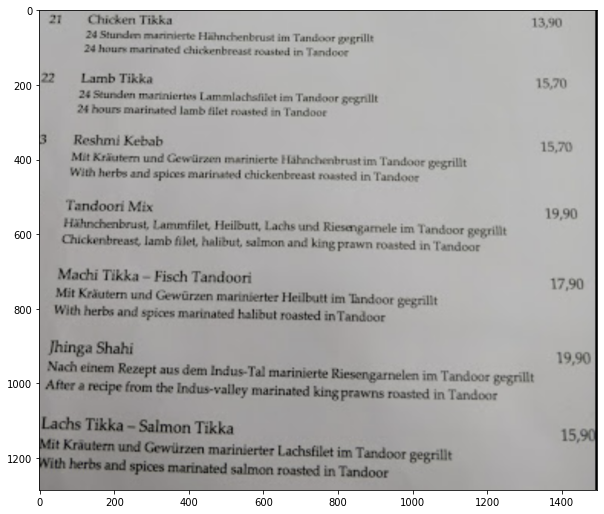

In [3]:
# keras-ocr will automatically download pretrained
# weights for the detector and recognizer.
pipeline = keras_ocr.pipeline.Pipeline()

images = [
    keras_ocr.tools.read(img) for img in ['im5.jpeg']
]

for image in images:
    plt.figure(figsize = (10,20))
    plt.imshow(image)

# OCR Model Ouput

/Users/I534344/opt/anaconda3/envs/ocr_model/lib/python3.8/site-packages/keras_ocr/tools.py:156: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.annotate(s=text,


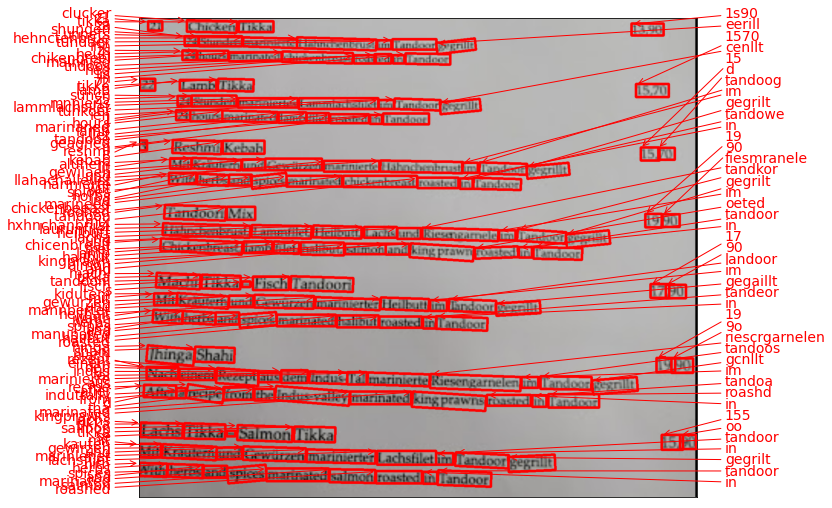

In [4]:
prediction_groups = pipeline.recognize(images)
plot_predictons(images, prediction_groups)

# Rule Based Line Detection

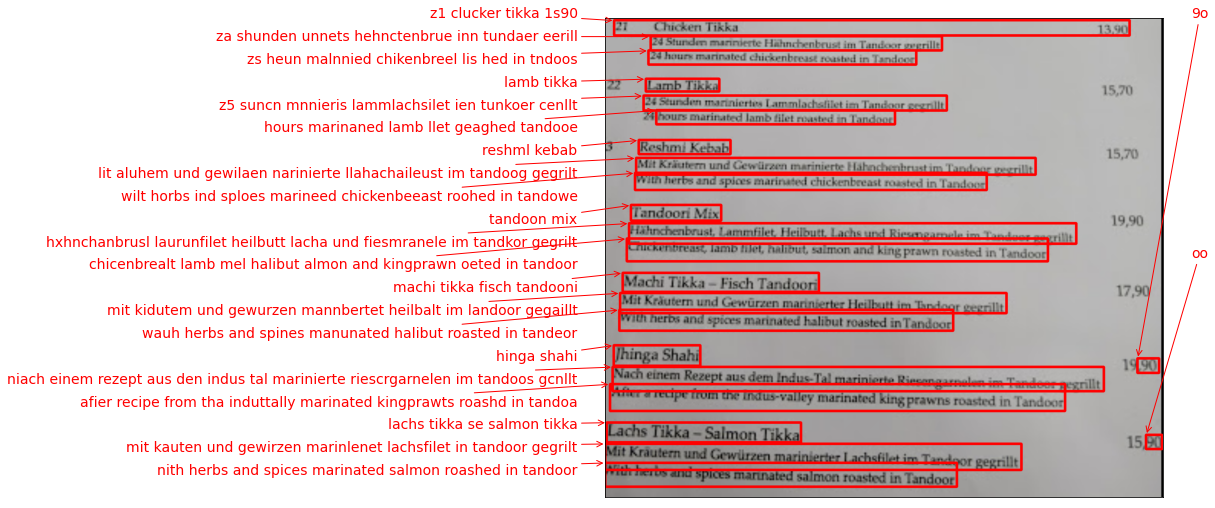

In [5]:
new_prediction_groups = []
for index_pred, single_image in enumerate(images):
    ocr, old_ocr_format = pipeline_lineboxes(images[index_pred], prediction_groups[index_pred])
    new_prediction_groups.append(old_ocr_format)
    
plot_predictons(images, new_prediction_groups)

# Rule Based Sentence Detection & Preprocessing

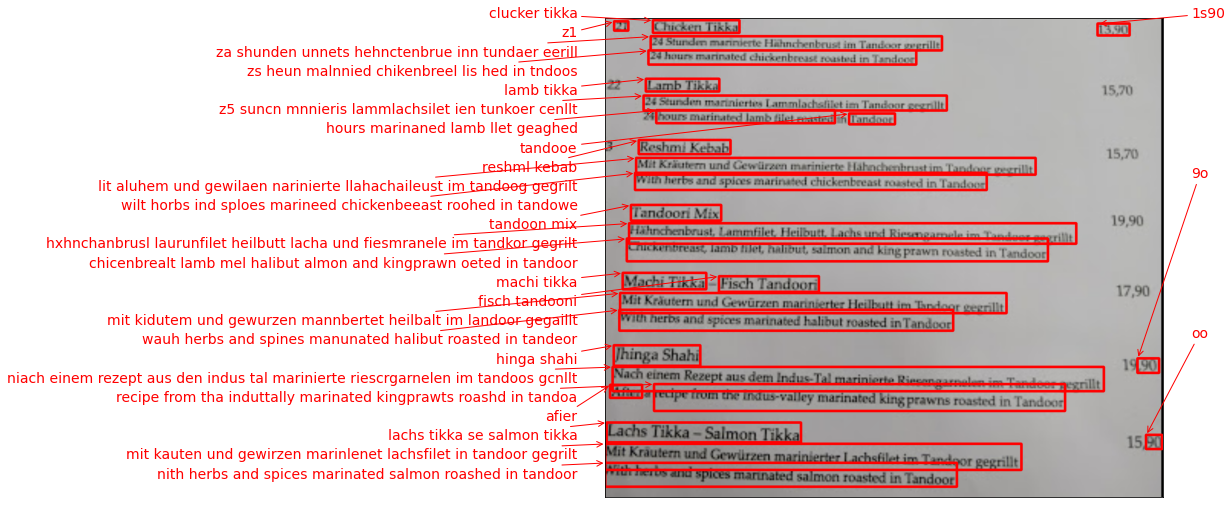

In [6]:
new_prediction_groups = []
for index_pred, single_image in enumerate(images):
    ocr, old_ocr_format = pipeline_sentences(images[index_pred], prediction_groups[index_pred])
    new_prediction_groups.append(old_ocr_format)

plot_predictons(images, new_prediction_groups)

# Dish Detection: Rule Based Look Up & Spelling Correction

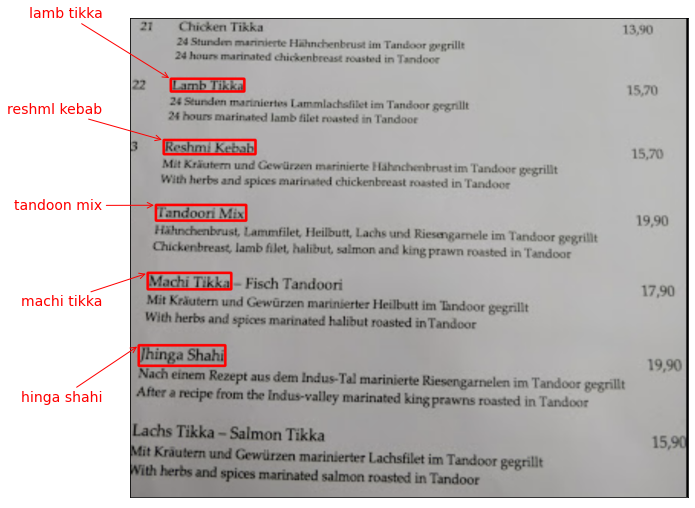

In [10]:
new_prediction_groups = []
for index_pred, single_image in enumerate(images):
    ocr, old_ocr_format = pipeline(images[index_pred], prediction_groups[index_pred])
    new_prediction_groups.append(old_ocr_format)

plot_predictons(images, new_prediction_groups)

![title]("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ5kacMzSMMd2c0NIJTf5U0t3R22HiRf1ZV_gyNf8CexCVX5LiSsNfQtFuBqRc&s")

First Menu: 


Lamb Tikka


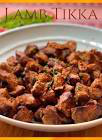



Reshml Kebab


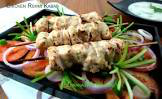



Tandoon Mix


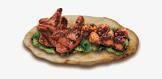



Machi Tikka


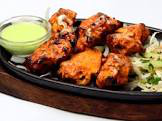



Hinga Shahi


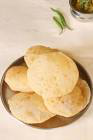

In [11]:
show_images(new_prediction_groups) 